In [1]:
import logging
logging.basicConfig(level=logging.INFO)

import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import click
from torch.utils.data import DataLoader,random_split,TensorDataset

from datamaestro import prepare_dataset
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np
from keras.datasets import mnist
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt

2023-11-21 12:18:47.404726: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-21 12:18:47.433935: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 12:18:47.953247: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [43]:
BATCH_SIZE = 311
TRAIN_RATIO = 0.05
LOG_PATH = "/tmp/runs/lightning_logs"



class LitMnistData(pl.LightningDataModule):

    def __init__(self,batch_size=BATCH_SIZE,train_ratio=TRAIN_RATIO):
        super().__init__()
        self.dim_in = None
        self.dim_out = None
        self.batch_size = batch_size
        self.train_ratio = train_ratio

    def prepare_data(self):
        ### Do not use "self" here.
        prepare_dataset("com.lecun.mnist")

    def setup(self,stage=None):
        ds = prepare_dataset("com.lecun.mnist")
        if stage =="fit" or stage is None:
            # Si on est en phase d'apprentissage
            shape = ds.train.images.data().shape
            self.dim_in = shape[1]*shape[2]
            self.dim_out = len(set(ds.train.labels.data()))
            ds_train = TensorDataset(torch.tensor(ds.train.images.data()).view(-1,self.dim_in).float()/255., torch.tensor(ds.train.labels.data()).long())
            train_length = int(shape[0]*self.train_ratio)
            self.mnist_train, self.mnist_val, = random_split(ds_train,[train_length,shape[0]-train_length])
        if stage == "test" or stage is None:
            # en phase de test
            self.mnist_test= TensorDataset(torch.tensor(ds.test.images.data()).view(-1,self.dim_in).float()/255., torch.tensor(ds.test.labels.data()).long())

    def train_dataloader(self):
        return DataLoader(self.mnist_train,batch_size=self.batch_size)
    def val_dataloader(self):
        return DataLoader(self.mnist_val,batch_size=self.batch_size)
    def test_dataloader(self):
        return DataLoader(self.mnist_test,batch_size=self.batch_size)





In [44]:
data = LitMnistData()
data.prepare_data()

data.setup()
train_loader = data.train_dataloader()
val_loader  = data.val_dataloader()
test_loader = data.test_dataloader()

In [45]:
dim_in = 784
dim_out = 10
train_length = 50000

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np

class MLP3(nn.Module):
    def __init__(self, dim_in, l, dim_out):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(dim_in, l), nn.ReLU(), nn.Linear(l, l), nn.ReLU(), nn.Linear(l, dim_out))

    def forward(self, x):
        x = self.model(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

epoch = 100
dim_latent = 100
model = MLP3(dim_in, dim_latent, dim_out).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

def train(train_loader, test_loader, model, optimizer, epoch, device):
    l_train = []
    l_test = []
    a_train = []
    a_test = []
    
    criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss directly

    for e in tqdm(range(epoch)):
        loss_train = []
        loss_test = []
        acc_train = []
        acc_test = []
        
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 10 == 0:
                loss_train.append(loss.item())
                acc_train.append((output.argmax(1).detach().to('cpu') == target.detach().to('cpu')).sum().item() / len(target))

        l_train.append(np.mean(loss_train))
        a_train.append(np.mean(acc_train))

        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                if batch_idx % 10 == 0:
                    loss_test.append(loss.item())
                    acc_test.append((output.argmax(1).detach().to('cpu') == target.detach().to('cpu')).sum().item() / len(target))

        l_test.append(np.mean(loss_test))
        a_test.append(np.mean(acc_test))
    
    return l_train, l_test, a_train, a_test


cpu


In [47]:
loss_train, loss_test, acc_train, acc_test = train(train_loader, val_loader, model, optimizer, epoch, device)

100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


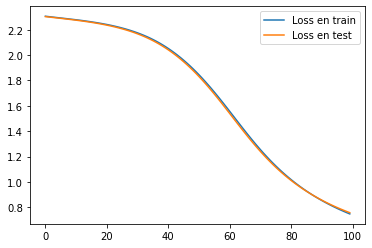

In [48]:
plt.figure()
plt.plot(loss_train,label="Loss en train")
plt.plot(loss_test,label="Loss en test")
plt.legend()
plt.show()

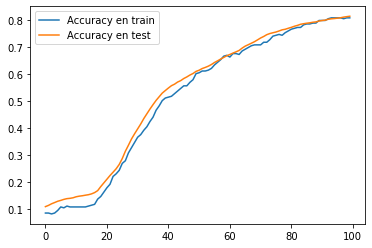

In [49]:
plt.figure()
plt.plot(acc_train,label="Accuracy en train")
plt.plot(acc_test,label="Accuracy en test")
plt.legend()
plt.show()

In [50]:
print("accuracy en train : ", acc_train[-1])
print("accuracy en test : ", acc_test[-1])

accuracy en train :  0.8070739549839229
accuracy en test :  0.812997123032662
